In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
     

In [11]:
data=pd.read_csv('mnist_train.csv')


In [12]:
rand=np.random.randint(0,data.shape[0],10000)
data=data.iloc[rand,:].reset_index()
data.drop(columns='index',inplace=True)
data

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
labels=data.iloc[:,0]
data=data.drop(columns='label',axis=1)
print(labels.shape)
print(data.shape)

(10000,)
(10000, 784)


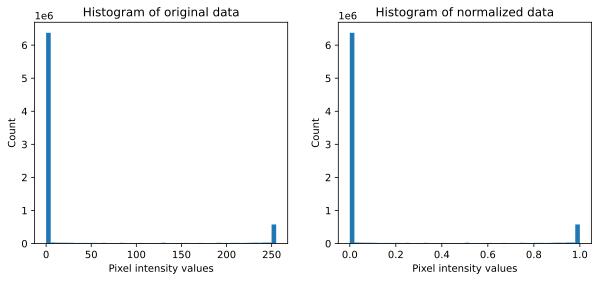

In [14]:
dataNorm = data/np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.values.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')

ax[1].hist(dataNorm.values.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

plt.show()

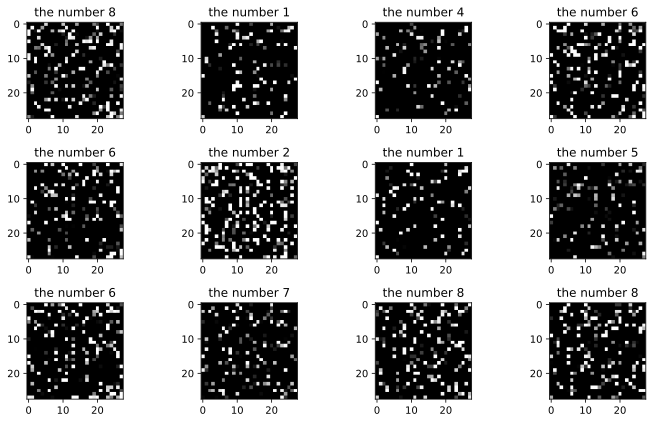

In [22]:
eggs=np.random.permutation(data.shape[1])
scrambled=dataNorm.values[:,eggs]
fig,axs=plt.subplots(3,4,figsize=(10,6))
for ax in axs.flatten():
    randimg2show=np.random.randint(0,data.shape[0])
    img=np.reshape(scrambled[randimg2show,:],(28,28))
    ax.imshow(img,cmap='gray')
    ax.set_title(f'the number {labels.iloc[randimg2show]}')
plt.tight_layout()

In [23]:
dataT   = torch.tensor( scrambled ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
     

In [24]:
# create a class for the model
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

              ### input layer
            self.input = nn.Linear(784,64)

              ### hidden layer
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)

              ### output layer
            self.output = nn.Linear(32,10)

    # forward pass
        def forward(self,x):
            x = F.relu( self.input(x) )
            x = F.relu( self.fc1(x) )
            x = F.relu( self.fc2(x) )
            return ( self.output(x))
          # NOTE: log-softmax the output (b/c loss function)

  # create the model instance
    net = mnistNet()
  
  # loss function
    lossfun = nn.CrossEntropyLoss()

  # optimizer
    optimizer = torch.optim.SGD(net.parameters(),lr=.01)

    return net,lossfun,optimizer
     


In [25]:
def function2trainTheModel():

      # number of epochs
    numepochs = 60

      # create a new model
    net,lossfun,optimizer = createTheMNISTNet()

      # initialize losses
    trainlosses = torch.zeros(numepochs)
    testlosses = torch.zeros(numepochs)
    
    trainAcc  = []
    testAcc   = []


      # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

          # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)

          # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # loss from this batch
            batchLoss.append(loss.item())

          # compute accuracy
            matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
            batchAcc.append( accuracyPct )               # add to list of accuracies
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # and get average losses across the batches
        trainlosses[epochi] = np.mean(batchLoss)

        # test accuracy
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)
        loss=lossfun(yHat,y)
        testlosses[epochi]=loss.item()

        # compare the following really long line of code to the training accuracy lines
        testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

      # end epochs
    return trainAcc,testAcc,trainlosses,testlosses,net


In [26]:


trainAcc,testAcc,trainlosses,testlosses,net = function2trainTheModel()

     


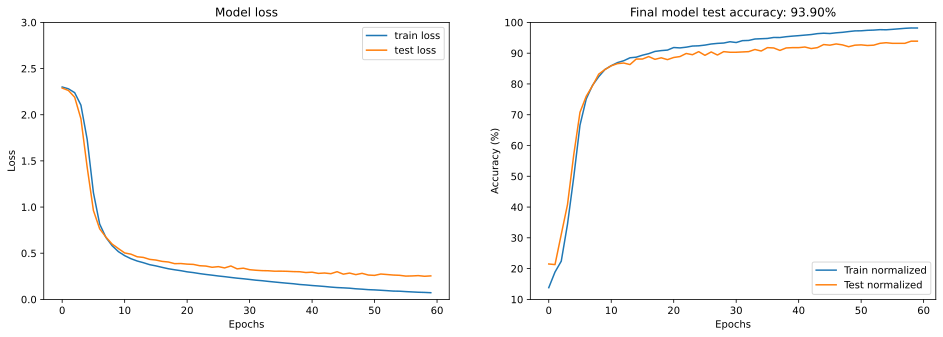

In [27]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainlosses,label='train loss')

ax[0].plot(testlosses,label='test loss')
ax[0].legend()

ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train normalized')
ax[1].plot(testAcc,label='Test normalized')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()
     